In [1]:
from heol_humanoid import HeolHumanoid

In [2]:
heol = HeolHumanoid(simulator='vrep')

<DxlMotor name=l_hip_motor_z id=42 pos=0>
<DxlMotor name=l_thigh_x id=43 pos=0>
<DxlMotor name=l_ankle_x id=45 pos=0>
<DxlMotor name=r_hip_y id=51 pos=0>
<DxlMotor name=r_hip_motor_z id=52 pos=0>
<DxlMotor name=r_thigh_x id=53 pos=0>
<DxlMotor name=r_ankle_x id=55 pos=0>
<DxlMotor name=spine_z id=11 pos=0>
<DxlMotor name=chest_x id=12 pos=0>
<DxlMotor name=l_shoulder_x id=31 pos=0>
<DxlMotor name=l_upper_arm_z id=33 pos=0>
<DxlMotor name=r_shoulder_x id=21 pos=0>
<DxlMotor name=r_upper_arm_z id=23 pos=0>
<DxlMotor name=head_z id=13 pos=0>
<DxlMotor name=r_shoulder_motor_y id=22 pos=0>
<DxlMotor name=l_shoulder_motor_y id=32 pos=0>


In [3]:
%pylab inline
import time

Populating the interactive namespace from numpy and matplotlib


In [17]:
from pypot.dynamixel import conversion
conversion.torque_max['XL-320']=1.0

In [4]:
from pypot.primitive import Primitive

In [5]:
class Graph_primitive(Primitive):
    def __init__(self,robot,motors_name):
        self.robot = robot
        Primitive.__init__(self, robot)
        self.fake_motors={}
        for name in motors_name:
            self.fake_motors[name] = getattr(self.robot, name)  
        self.position={}
        self.load={}
        self.speed={}
        
    def setup(self):
        for m in self.fake_motors.keys():
            self.position[m] = []
            self.speed[m] = []
            self.load[m] = []
        self.python_time=[]
        self.pypot_time=[]
    
    def run(self):
        t0 = time.time()
        while not self.should_stop():
            for m in self.fake_motors.keys():
                self.position[m].append(self.fake_motors[m].present_position)
                self.load[m].append(self.fake_motors[m].present_load)
                self.speed[m].append(self.fake_motors[m].present_speed)
            self.python_time.append(time.time()-t0)
            self.pypot_time.append(self.elapsed_time)
            time.sleep(0.02)
            
            

In [6]:
graph = Graph_primitive(heol,['l_hip_y','r_hip_y'])

In [7]:
graph.start()

In [8]:
graph.stop()

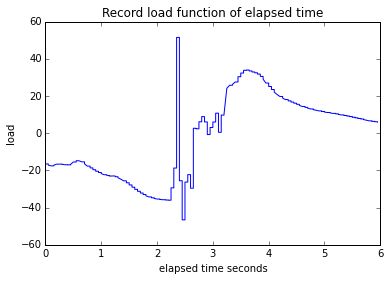

In [40]:
figure(1)
plot(graph.pypot_time,graph.load['l_hip_y'])
xlabel('elapsed time seconds')
ylabel('load')
title ('Record load function of elapsed time')

In [6]:
class Filter_PID:
    def __init__(self,nb_record=10,goal=0):
        self.nb_record = nb_record
        self.goal = goal
        self.record_pos=[0 for i in range(nb_record)]
        self.filter_load=[[0,0] for i in range(nb_record*10)]
        
    def add(self,l,t):
        self.record_pos.append(l-self.goal)
        del self.record_pos[0]
        self.filter_load.append([t,sum(self.record_pos)/len(self.record_pos)])
        del self.filter_load[0]
    
    def integrate(self,nb_values=10):
        x=[i[0] for i in self.filter_load]
        y=[i[1] for i in self.filter_load]
        return np.trapz(y[-nb_values-1:-1],x[-nb_values-1:-1])
       
    def derivative(self):
        if self.filter_load[-1][0] != 0:
            return ((self.filter_load[-1][1]+self.filter_load[-2][1])/2-(self.filter_load[-10][1]+self.filter_load[-9][1])/2)/((self.filter_load[-1][0]+self.filter_load[-2][0])/2-(self.filter_load[-10][0]+self.filter_load[-9][0])/2)
        else :
            return 0
    
    def last(self):
        return self.filter_load[-1][1]

In [7]:
class Load_primitive(Primitive):
    def __init__(self,robot,motors_name):
        self.robot = robot
        Primitive.__init__(self, robot)  
        self.fake_motors={}
        for name in motors_name:
            self.fake_motors[name] = getattr(self.robot, name)  
        self.load={}
        self.filter_load={}
       
    def setup(self):
        for m in self.fake_motors.keys():
            self.load[m] = Filter_PID(20)
            self.filter_load[m]=[]
        self.pypot_time=[]
        
    
    def run(self):
        t0 = time.time()
        while not self.should_stop():
            for m in self.fake_motors.keys():
                self.load[m].add(self.fake_motors[m].present_load,self.elapsed_time)
                self.filter_load[m].append(self.load[m].last())
            self.pypot_time.append(self.elapsed_time)
            time.sleep(0.02)

In [11]:
load = Load_primitive(heol,['l_hip_y','r_hip_y'])

In [268]:
load.start()

In [27]:
# préparation
heol.l_shoulder_x.goto_position(90,1)
heol.r_shoulder_x.goto_position(90,1)

heol.l_thigh_x.goto_position(-10,1)
heol.l_ankle_x.goto_position(-10,1)

heol.r_thigh_x.goto_position(10,1)
heol.r_ankle_x.goto_position(10,1)

In [28]:
for i in range(3):
    # mouvement à gauche
    # déséquilibre avant
    heol.l_thigh_x.goto_position(-23,0.5)
    heol.r_thigh_x.goto_position(-3,0.5,wait=True)
    heol.r_ankle_x.goto_position(0,0.5)
    heol.l_hip_y.goto_position(15,0.5)
    heol.l_foot_y.goto_position(-15,0.5)
    heol.r_hip_y.goto_position(-5,0.5,wait=True)
    # lancé de pied
    heol.r_knee_x.goto_position(60,0.2)
    heol.r_thigh_x.goto_position(-60,0.2)
    heol.l_hip_y.goto_position(18,0.2)
    heol.l_foot_y.goto_position(-18,0.2,wait=True)
    #rétablir en chutant sur l'avant
    heol.l_thigh_x.goto_position(10,0.2)
    heol.l_ankle_x.goto_position(10,0.2,wait=True)
    heol.r_ankle_x.goto_position(-10,0.1)
    heol.r_knee_x.goto_position(0,0.1)
    heol.r_thigh_x.goto_position(-10,0.1)
    heol.l_hip_y.goto_position(0,0.1)
    heol.l_foot_y.goto_position(0,0.1)
    heol.r_hip_y.goto_position(0,0.1,wait=True)
    time.sleep(0.5)
    # mouvement à droite
    # déséquilibre avant
    heol.r_thigh_x.goto_position(-23,0.5)
    heol.l_thigh_x.goto_position(-3,0.5,wait=True)
    heol.l_ankle_x.goto_position(0,0.5)
    heol.r_hip_y.goto_position(15,0.5)
    heol.r_foot_y.goto_position(15,0.5)
    heol.l_hip_y.goto_position(-5,0.5,wait=True)
    # lancé de pied
    heol.l_knee_x.goto_position(60,0.2)
    heol.l_thigh_x.goto_position(-60,0.2)
    heol.r_hip_y.goto_position(18,0.2)
    heol.r_foot_y.goto_position(18,0.2,wait=True)
    #rétablir en chutant sur l'avant
    heol.r_thigh_x.goto_position(10,0.2)
    heol.r_ankle_x.goto_position(10,0.2,wait=True)
    heol.l_ankle_x.goto_position(-10,0.1)
    heol.l_knee_x.goto_position(0,0.1)
    heol.l_thigh_x.goto_position(-10,0.1)
    heol.r_hip_y.goto_position(0,0.1)
    heol.r_foot_y.goto_position(0,0.1)
    heol.l_hip_y.goto_position(0,0.1,wait=True)
    time.sleep(0.5)


In [269]:
load.stop()

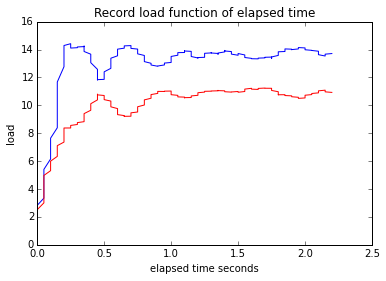

In [270]:
figure(1)
plot(load.pypot_time,load.filter_load['l_hip_y'],'b-')
plot(load.pypot_time,load.filter_load['r_hip_y'],'r-')
xlabel('elapsed time seconds')
ylabel('load')
title ('Record load function of elapsed time')

In [181]:
for m in heol.motors:
    m.goto_position(0,1)

In [180]:
heol.reset_simulation()

In [305]:
from pypot.dynamixel import conversion
conversion.torque_max['XL-320']=3.0

In [306]:
conversion.torque_max

{'AX-12': 1.2,
 'AX-18': 1.8,
 'MX-106': 8.4,
 'MX-12': 1.2,
 'MX-28': 2.5,
 'MX-64': 6.0,
 'RX-28': 2.5,
 'RX-64': 4.0,
 'XL-320': 3.0}

###Marche équilibrée

In [147]:
heol.l_knee_x.goto_position(10,1)
heol.l_thigh_x.goto_position(-10,1)
heol.l_ankle_x.goto_position(10,1)
heol.l_foot_y.goto_position(-15,1)
heol.r_foot_y.goto_position(-10,1)
heol.l_hip_y.goto_position(15,1)
heol.r_hip_y.goto_position(-10,1,wait=True)
heol.r_thigh_x.goto_position(-40,1)
heol.r_knee_x.goto_position(20,1)
heol.r_ankle_x.goto_position(-10,1)
heol.r_hip_y.goto_position(0,1)
heol.r_foot_y.goto_position(0,1,wait=True)
heol.l_thigh_x.goto_position(30,2)
heol.l_ankle_x.goto_position(30,2)
heol.r_thigh_x.goto_position(-40,1)
heol.r_knee_x.goto_position(20,1)
heol.r_ankle_x.goto_position(-20,1,wait=True)
heol.r_hip_y.goto_position(15,1)
heol.r_foot_y.goto_position(15,1)
heol.chest_x.goto_position(-40,1)
heol.r_shoulder_x.goto_position(40,1)
heol.l_shoulder_x.goto_position(40,1,wait=True)
heol.l_ankle_x.goto_position(50,2)
heol.l_knee_x.goto_position(30,1,wait=True)
heol.l_thigh_x.goto_position(0,1)
heol.l_knee_x.goto_position(70,1)
heol.l_ankle_x.goto_position(70,2)
heol.l_hip_y.goto_position(5,2,wait=True)
heol.l_thigh_x.goto_position(-50,1)
heol.l_knee_x.goto_position(90,1)
heol.l_ankle_x.goto_position(40,2,wait=True)
heol.r_thigh_x.goto_position(-0,1)
heol.r_knee_x.goto_position(0,1)
heol.r_ankle_x.goto_position(-0,1)
heol.chest_x.goto_position(0,1)
heol.r_shoulder_x.goto_position(0,1)
heol.l_shoulder_x.goto_position(0,1,wait=True)
heol.l_thigh_x.goto_position(-40,1)
heol.l_knee_x.goto_position(0,2)
heol.l_ankle_x.goto_position(-40,2,wait=True)
heol.l_foot_y.goto_position(-5,1)
heol.r_thigh_x.goto_position(22,1)
heol.r_knee_x.goto_position(0,1)
heol.r_ankle_x.goto_position(22,1,wait=True)
heol.l_thigh_x.goto_position(-30,1)
heol.l_knee_x.goto_position(0,1)
heol.l_ankle_x.goto_position(-30,1,wait=True)
heol.r_thigh_x.goto_position(30,1)
heol.r_knee_x.goto_position(0,1)
heol.r_ankle_x.goto_position(30,1)


In [137]:
heol.l_ankle_x.goto_position(-30,1,wait=True)

In [254]:
for m in heol.motors:
    m.goto_position(0,1)

###Marche en déséquilibre

In [311]:
heol.r_shoulder_x.goto_position(30,0.5)
heol.l_shoulder_x.goto_position(30,0.5)

In [312]:
heol.l_ankle_x.goto_position(-20,0.1)
heol.l_knee_x.goto_position(40,0.1)
heol.l_thigh_x.goto_position(-40,0.1)
heol.r_ankle_x.goto_position(20,0.1)
heol.r_thigh_x.goto_position(20,0.1,wait=True)

heol.l_knee_x.goto_position(0,0.2)
heol.l_thigh_x.goto_position(-20,0.1)
heol.l_ankle_x.goto_position(-20,0.1)


In [315]:


heol.l_ankle_x.goto_position(0,0.1)
heol.l_thigh_x.goto_position(0,0.1)

heol.r_ankle_x.goto_position(-20,0.1)
heol.r_knee_x.goto_position(40,0.1)
heol.r_thigh_x.goto_position(-40,0.1,wait=True)


heol.l_thigh_x.goto_position(20,0.1)
heol.l_ankle_x.goto_position(20,0.1)

heol.r_knee_x.goto_position(0,0.1)
heol.r_thigh_x.goto_position(-20,0.1)
heol.r_ankle_x.goto_position(-20,0.1,wait=True)


In [314]:
heol.r_ankle_x.goto_position(0,0.1)
heol.r_thigh_x.goto_position(0,0.1)

heol.l_ankle_x.goto_position(-20,0.1)
heol.l_knee_x.goto_position(40,0.1)
heol.l_thigh_x.goto_position(-40,0.1,wait=True)


heol.r_thigh_x.goto_position(20,0.1)
heol.r_ankle_x.goto_position(20,0.1)

heol.l_knee_x.goto_position(0,0.1)
heol.l_thigh_x.goto_position(-20,0.1)
heol.l_ankle_x.goto_position(-20,0.1,wait=True)


In [298]:
for i in range(3):
    heol.r_ankle_x.goto_position(0,0.1)
    heol.r_thigh_x.goto_position(0,0.1)

    heol.l_ankle_x.goto_position(-20,0.1)
    heol.l_knee_x.goto_position(40,0.1)
    heol.l_thigh_x.goto_position(-40,0.1,wait=True)


    heol.r_thigh_x.goto_position(20,0.1)
    heol.r_ankle_x.goto_position(20,0.1)

    heol.l_knee_x.goto_position(0,0.1)
    heol.l_thigh_x.goto_position(-20,0.1)
    heol.l_ankle_x.goto_position(-20,0.1,wait=True)

    time.sleep(0.1)
    
    heol.l_ankle_x.goto_position(0,0.1)
    heol.l_thigh_x.goto_position(0,0.1)

    heol.r_ankle_x.goto_position(-20,0.1)
    heol.r_knee_x.goto_position(40,0.1)
    heol.r_thigh_x.goto_position(-40,0.1,wait=True)


    heol.l_thigh_x.goto_position(20,0.1)
    heol.l_ankle_x.goto_position(20,0.1)

    heol.r_knee_x.goto_position(0,0.1)
    heol.r_thigh_x.goto_position(-20,0.1)
    heol.r_ankle_x.goto_position(-20,0.1,wait=True)

In [223]:
heol.l_ankle_x.goto_position(20,0.2)
heol.l_thigh_x.goto_position(20,0.2)

In [227]:

heol.r_knee_x.goto_position(10,0.1)



In [229]:
heol.l_hip_y.goto_position(10,0.1)
heol.l_foot_y.goto_position(-10,0.1)


In [245]:
heol.l_thigh_x.goto_position(-20,0.1)
heol.l_ankle_x.goto_position(-20,0.1)

heol.r_thigh_x.goto_position(20,0.1)
heol.r_ankle_x.goto_position(20,0.1)


In [246]:
heol.l_thigh_x.goto_position(0,0.1)
heol.l_ankle_x.goto_position(0,0.1)



In [ ]:
heol.r_thigh_x.goto_position(-20,0.1)
heol.r_ankle_x.goto_position(-20,0.1)

In [316]:

heol.reset_simulation()

In [186]:
heol.r_ankle_x.goto_position(20,1)
heol.r_thigh_x.goto_position(20,1,wait=True)

In [150]:
heol.r_ankle_x.compliant = True
heol.r_foot_y.compliant = True

In [154]:
heol.r_knee_x.compliant = True
heol.l_knee_x.compliant = True

In [90]:
from pypot.primitive import Primitive
import time
class wait_primitive(Primitive):
    def run(self):
        for m in self.robot.motors:
            ecart = m.goal_position - m.present_position
            print ecart
        

In [91]:
wait = wait_primitive(heol)

In [92]:
wait.start()
time.sleep(1)

-1.05727784988e-06
0.00115288561428
0.458600986071
-0.0495459842183
-3.16034528435e-06
6.17553514193e-06
9.92917163123e-07
0.00758281731961
0.0115787971989
-0.00539134277615
-0.00135769196733
0.0115787971989
-0.0173681957983
0.0173681957983
-0.00130927699849
-0.0115787971989
-6.278755286e-06
4.80744656769e-09
0.0374334820713
0.0115787971989
-0.010652493423
0.00336482324212
-0.00157531586821


In [204]:

heol.reset_simulation()

In [303]:
heol.close()

In [205]:
# préparation
heol.l_shoulder_x.goto_position(0,1)
heol.r_shoulder_x.goto_position(0,1)

heol.l_thigh_x.goto_position(-20,1)
heol.l_ankle_x.goto_position(-20,1)

heol.r_thigh_x.goto_position(20,1)
heol.r_ankle_x.goto_position(20,1)

In [207]:
heol.r_ankle_x.compliant = True
heol.l_ankle_x.compliant = True


In [206]:
heol.l_knee_x.goto_position(50,1)
heol.l_thigh_x.goto_position(-41,1)

In [34]:
heol.l_thigh_x.goto_position(-5,1)

In [190]:
heol.reset_simulation()

In [ ]:
from math import *


In [168]:
def thigh_angle(e1,e2,knee_x):
    # a is the lengh of the thigh, b the lengh of the shin.
    # e1 is the angle between the vertical and the rear leg, e2 the angle between verticale and the front leg
    # E is the angle between the two legs
    a = 1
    b = 1
    E = radians(-e1+e2)

    # e is the gap between each leg:
    e = sqrt((a+b)**2+(a+b)**2-(2*(a+b)*(a+b)*cos(E)))
    
    # flex is the angle flexion of the knee 
    flex = pi - radians(knee_x)

    ## now after the flexion
    # h is the high of the perlvis 
    h = sqrt(a**2+b**2-(2*a*b*cos(flex)))

    # r1 is the angle between h and rear leg
    r1 = acos(((a+b)**2+h**2-e**2)/(2*(a+b)*h))

    # r2 is the angle between h and front leg
    r2 = acos((a**2+h**2-b**2)/(2*a*h))

    # R is the new angle between the leg after the knee flexion
    R = r1 + r2

    # It is possible to freely set the angle for each thigh respecting the rule t2 - t1 = R
    # with t1 the rear leg and t2 the front with the flexion
    # If you want to not change the initiale angle just set t1 = e1, so t2 = R + e1
    t2 = degrees(R) + e1
    
    return t2

In [163]:
# a is the lengh of the thigh, b the lengh of the shin.
# e1 is the angle between the vertical and the rear leg, e2 the angle between verticale and the front leg
# E is the angle between the two legs
a = 1
b = 1
E = radians(-10+10)

# e is the gap between each leg:
e = sqrt((a+b)**2+(a+b)**2-(2*(a+b)*(a+b)*cos(E)))

# flex is the angle flexion of the knee 
flex = pi - radians(0)

## now after the flexion
# h is the high of the perlvis 
h = sqrt(a**2+b**2-(2*a*b*cos(flex)))

# r1 is the angle between h and rear leg
r1 = acos(((a+b)**2+h**2-e**2)/(2*(a+b)*h))

# r2 is the angle between h and front leg
r2 = acos((a**2+h**2-b**2)/(2*a*h))

# R is the new angle between the leg after the knee flexion
R = r1 + r2

# It is possible to freely set the angle for each thigh respecting the rule t2 - t1 = R
# with t1 the rear leg and t2 the front with the flexion
# If you want to not change the initiale angle just set t1 = e1, so t2 = R + e1
t2 = degrees(R)

In [167]:
e

0.0

In [199]:
thigh_angle(-20,20,60)

52.25032073933099

In [177]:
i=0
knee=[]
thigh=[]
while i<140:
    knee.append(i)
    thigh.append(thigh_angle(-20,20,i))                 
    i += 0.1
    

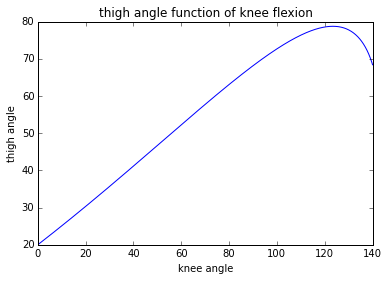

In [178]:
figure(1)
plot(knee,thigh)
xlabel('knee angle')
ylabel('thigh angle')
title ('thigh angle function of knee flexion')

In [128]:
degrees(r1)

19.8261604608166

In [129]:
degrees(r2)

30.000000000000004

In [130]:
t2

49.8261604608166